# 01 — Exploratory Data Analysis (EDA)

> **Objective:** To examine the NGS (National Graduate Survey) structured hiring dataset, characterize its feature structure, and motivate the design of the preprocessing and feature engineering pipeline used for overqualification prediction.

This notebook outlines the following stages:
1. [**Dataset loading**](#load-the-dataset) — importing the raw data and verifying structure  
2. [**Schema and missing-value assessment**](#schema-and-missing-value-assessment) — checking data types and completeness  
3. [**Target distribution**](#target-distribution) — class balance for overqualification  
4. [**Feature distributions**](#feature-distributions) — survey code columns and value ranges  
5. [**Feature–target relationships**](#feature-target-relationships) — associations with overqualification  
6. [**Summary**](#summary-of-exploratory-findings) — implications for the ML pipeline

> **Note:** Run `python3 -m src.train` from the project root before running later notebooks if the model has not been trained yet.

### 🧠 Context & Hackathon Goal

This notebook supports the **SFU Data Science Student Society ML Hackathon** project using the **NGS structured hiring dataset**. The goal is to predict **overqualification** (candidates whose profiles exceed role requirements) from candidate attributes such as education level, program of study, prior experience, and demographics.

The EDA here is **not** used for training — model training occurs in the source module `src/train.py`. Instead, this notebook provides the statistical and structural motivation for:

- **Preprocessing** — handling NGS special codes (6, 9, 99 = valid skip / refused / not stated) and mixed-type columns (e.g. GENDER2, DDIS_FL with text and numeric values)  
- **Feature engineering** — treating survey-code columns as categorical for CatBoost  
- **Validation** — stratified splits and accuracy as the evaluation metric aligned with the hackathon leaderboard

---
### 🧰 Imports <a id="imports"></a>

Libraries used in this EDA:

- **pandas** — data loading and tabular manipulation  
- **numpy** — numerical utilities  
- **matplotlib.pyplot** and **seaborn** — visualizations  
- **pathlib** and **sys** — path setup so `src` modules can be imported when the notebook is run from `notebooks/`

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Allow importing src when running from notebooks/
sys.path.insert(0, str(Path().resolve().parent))

sns.set(style="whitegrid")

### 📥 Load the Dataset <a id="load-the-dataset"></a>

Load the training CSV from `data/raw/` and inspect shape and first rows.

In [2]:
from src.config import TRAIN_CSV

df = pd.read_csv(TRAIN_CSV)
df.head()

,id,CERTLEVP,PGMCIPAP,PGM_P034,PGM_P036,PGM_280A,PGM_280B,PGM_280C,PGM_280F,PGM_P401,...,GRADAGEP,GENDER2,CTZSHIPP,VISBMINP,DDIS_FL,PAR1GRD,PAR2GRD,BEF_P140,BEF_160,overqualified
0,187,1.0,4.0,1.0,6.0,2.0,1.0,9.0,2.0,NaN,...,1.0,2.0,2.0,1.0,2.0,3.0,9.0,3.0,4.0,0
1,5343,2.0,5.0,1.0,6.0,2.0,6.0,2.0,9.0,2.0,...,1.0,2.0,1.0,2.0,1.0,3.0,6.0,3.0,6.0,0
2,7011,2.0,99.0,1.0,6.0,2.0,2.0,2.0,1.0,1.0,...,1.0,2.0,2.0,1.0,2.0,NaN,2.0,3.0,3.0,0
3,1519,1.0,7.0,1.0,6.0,2.0,2.0,2.0,1.0,1.0,...,4.0,9.0,2.0,2.0,NaN,6.0,3.0,1.0,NaN,0
4,6770,2.0,5.0,9.0,1.0,2.0,9.0,2.0,1.0,2.0,...,1.0,NaN,1.0,2.0,1.0,6.0,6.0,3.0,3.0,0


The NGS dataset is at the **individual respondent** level (one row per graduate). Columns are survey-derived codes:

| Column | Meaning (typical NGS usage) |
|--------|-----------------------------|
| `id` | Respondent identifier |
| `CERTLEVP` | Certificate / education level |
| `PGMCIPAP`, `PGM_P034`, `PGM_P036`, `PGM_280A`–`PGM_280F`, `PGM_P401` | Program / field of study (CIP codes) |
| `STULOANS` | Student loans |
| `DBTOTGRD` | Debt at graduation |
| `SCHOLARP` | Scholarship / financial support |
| `PREVLEVP` | Previous education level |
| `HLOSGRDP` | Employment / hours or status post-graduation |
| `GRADAGEP` | Age at graduation |
| `GENDER2` | Gender |
| `CTZSHIPP` | Citizenship |
| `VISBMINP` | Visible minority |
| `DDIS_FL` | Disability flag |
| `PAR1GRD`, `PAR2GRD` | Parent education |
| `BEF_P140`, `BEF_160` | Pre-graduation / labour market indicators |
| `overqualified` | **Target:** 1 = overqualified, 0 = not |

### 🧾 Schema and Null Overview <a id="schema-and-missing-value-assessment"></a>

`df.info()` summarizes column types and non-null counts. NGS often uses **6, 9, 99** as valid skip / refused / not stated; these are stored as numeric and will be treated as missing in preprocessing.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7709 entries, 0 to 7708
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7709 non-null   int64  
 1   CERTLEVP       7359 non-null   float64
 2   PGMCIPAP       7332 non-null   float64
 3   PGM_P034       7321 non-null   float64
 4   PGM_P036       7334 non-null   float64
 5   PGM_280A       7367 non-null   float64
 6   PGM_280B       7316 non-null   float64
 7   PGM_280C       7315 non-null   float64
 8   PGM_280F       7326 non-null   float64
 9   PGM_P401       7338 non-null   float64
 10  STULOANS       7346 non-null   float64
 11  DBTOTGRD       7345 non-null   float64
 12  SCHOLARP       7325 non-null   float64
 13  PREVLEVP       7333 non-null   float64
 14  HLOSGRDP       7315 non-null   float64
 15  GRADAGEP       7314 non-null   float64
 16  GENDER2        7334 non-null   object 
 17  CTZSHIPP       7309 non-null   float64
 18  VISBMINP

#### 🔎 Missing and special-code check

Count explicit nulls and the number of cells with NGS missing codes (6, 9, 99).

In [4]:
missing_codes = {6.0, 9.0, 99.0}
print("Explicit nulls per column:")
print(df.isnull().sum())
print("\nCount of values in {6, 9, 99} (to be treated as missing in preprocessing):")
for col in df.select_dtypes(include=[np.number]).columns:
    if col in ("id", "overqualified"):
        continue
    n = df[col].isin(missing_codes).sum()
    if n > 0:
        print(f"  {col}: {n}")

Explicit nulls per column:
id                 0
CERTLEVP         350
PGMCIPAP         377
PGM_P034         388
PGM_P036         375
PGM_280A         342
PGM_280B         393
PGM_280C         394
PGM_280F         383
PGM_P401         371
STULOANS         363
DBTOTGRD         364
SCHOLARP         384
PREVLEVP         376
HLOSGRDP         394
GRADAGEP         395
GENDER2          375
CTZSHIPP         400
VISBMINP         367
DDIS_FL          345
PAR1GRD          403
PAR2GRD          382
BEF_P140         387
BEF_160          398
overqualified      0
dtype: int64

Count of values in {6, 9, 99} (to be treated as missing in preprocessing):
  CERTLEVP: 435
  PGMCIPAP: 1886
  PGM_P034: 446
  PGM_P036: 6033
  PGM_280A: 1033
  PGM_280B: 1015
  PGM_280C: 1010
  PGM_280F: 1016
  PGM_P401: 983
  STULOANS: 1004
  DBTOTGRD: 5754
  SCHOLARP: 5252
  PREVLEVP: 3922
  HLOSGRDP: 541
  GRADAGEP: 188
  CTZSHIPP: 658
  PAR1GRD: 1313
  PAR2GRD: 1483
  BEF_P140: 541
  BEF_160: 3654


### 📊 Target Distribution <a id="target-distribution"></a>

Class balance for `overqualified` (1 = overqualified, 0 = not). Affects choice of metric and stratification in cross-validation.

overqualified
0    4745
1    2964
Name: count, dtype: int64


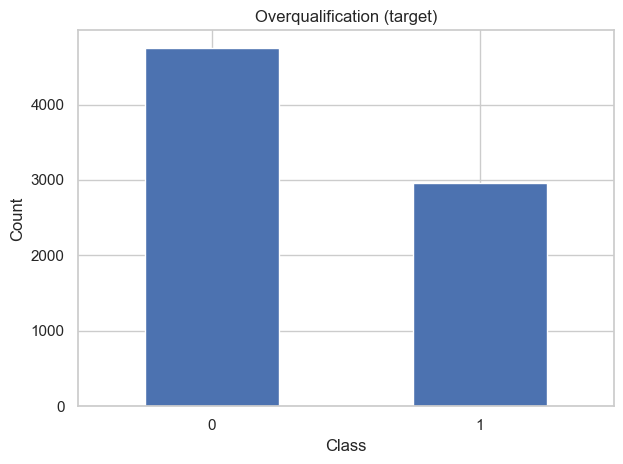

In [5]:
print(df["overqualified"].value_counts())
df["overqualified"].value_counts().plot(kind="bar", title="Overqualification (target)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 📈 Feature Distributions <a id="feature-distributions"></a>

Numeric (code) columns: value ranges and value counts for a few key features.

In [6]:
feature_cols = [c for c in df.columns if c not in ("id", "overqualified")]
df[feature_cols].describe()

,CERTLEVP,PGMCIPAP,PGM_P034,PGM_P036,PGM_280A,PGM_280B,PGM_280C,PGM_280F,PGM_P401,STULOANS,DBTOTGRD,SCHOLARP,PREVLEVP,HLOSGRDP,GRADAGEP,CTZSHIPP,PAR1GRD,PAR2GRD,BEF_P140,BEF_160
count,7359.000000,7332.000000,7321.000000,7334.00000,7367.000000,7316.000000,7315.000000,7326.000000,7338.000000,7346.000000,7345.000000,7325.000000,7333.000000,7315.000000,7314.000000,7309.000000,7306.000000,7327.000000,7322.000000,7311.000000
mean,2.519228,11.708947,1.679415,5.45514,2.737478,2.684527,2.695420,2.004505,2.287135,2.335148,5.483186,5.172014,4.490659,2.599316,2.190593,2.121220,2.789625,2.694827,2.674816,11.971686
std,1.853460,22.729485,1.905363,1.89995,1.973428,1.982696,1.977913,2.253093,2.164176,2.116320,1.987439,2.206232,2.521663,1.944351,1.433723,2.287271,2.520760,2.748827,2.087053,25.990620
min,1.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,4.000000,1.000000,6.00000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,6.000000,4.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
50%,2.000000,6.000000,1.000000,6.00000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,6.000000,6.000000,6.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,5.000000
75%,3.000000,9.000000,2.000000,6.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6.000000,6.000000,6.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,6.000000
max,9.000000,99.000000,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,10.000000,9.000000,9.000000,9.000000,99.000000


In [7]:
# Sample: value counts for a few columns (survey codes)
for col in ["CERTLEVP", "GENDER2", "PREVLEVP"]:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts(dropna=False).head(12))


CERTLEVP:
CERTLEVP
2.0    2721
3.0    1960
1.0    1947
9.0     435
NaN     350
5.0     171
4.0     125
Name: count, dtype: int64

GENDER2:
GENDER2
2.0       3993
1.0       2779
NaN        375
Female     252
Male       160
3.0         76
9.0         73
0.0          1
Name: count, dtype: int64

PREVLEVP:
PREVLEVP
6.0    3074
2.0    2115
9.0     848
3.0     650
1.0     640
NaN     376
5.0       4
7.0       2
Name: count, dtype: int64


### 🔗 Feature–Target Relationships <a id="feature-target-relationships"></a>

For numeric-coded features, we can look at mean overqualification rate by code (or correlation with target).

In [8]:
# Correlation of numeric features with target
numeric = df.select_dtypes(include=[np.number])
if "overqualified" in numeric.columns:
    corr_with_target = numeric.corr()["overqualified"].drop("overqualified", errors="ignore")
    corr_with_target = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)
    print("Correlation with overqualified (sorted by absolute value):")
    print(corr_with_target.head(15))

Correlation with overqualified (sorted by absolute value):
PGM_P036   -0.117949
CERTLEVP    0.052153
SCHOLARP    0.051928
GRADAGEP    0.047385
CTZSHIPP    0.036814
PAR1GRD    -0.035460
PGM_P034    0.035006
PGM_P401    0.033899
PGM_280B   -0.027808
BEF_P140   -0.026455
PGM_280C   -0.017613
PREVLEVP   -0.017140
HLOSGRDP    0.016722
PGM_280F    0.011870
PGM_280A    0.011798
Name: overqualified, dtype: float64


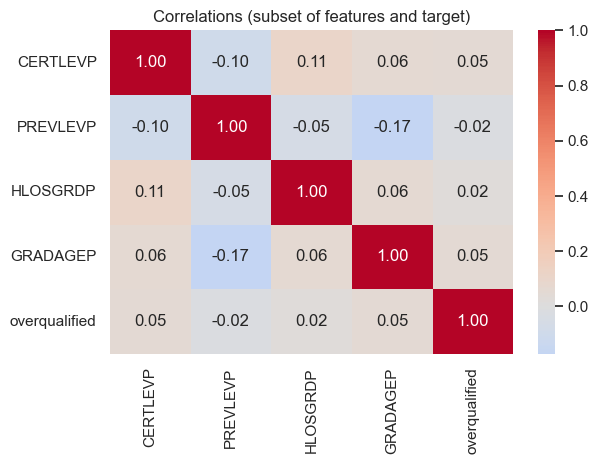

In [9]:
# Heatmap of correlations among a subset of features + target
cols_subset = ["CERTLEVP", "PREVLEVP", "HLOSGRDP", "GRADAGEP", "overqualified"]
cols_subset = [c for c in cols_subset if c in df.columns]
sns.heatmap(df[cols_subset].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlations (subset of features and target)")
plt.tight_layout()
plt.show()

---
## 📝 Summary of Exploratory Findings <a id="summary-of-exploratory-findings"></a>

Key observations that drive the ML pipeline:

- **Survey-code structure:** Most columns are categorical (education, program, demographics). Preprocessing will map NGS missing codes (6, 9, 99) to a single "missing" category and normalize mixed-type columns (e.g. GENDER2, DDIS_FL) to consistent codes.

- **Target balance:** Binary target with moderate class imbalance; stratified splits and accuracy (or F1) are appropriate. The hackathon used **accuracy** on the leaderboard.

- **Feature–target associations:** Some code columns show meaningful correlation with overqualification; CatBoost can exploit categorical and nonlinear relationships without one-hot expansion.

**Next step:** Continue to `02_preprocessing_feature_engineering.ipynb` to implement cleaning and categorical feature preparation for CatBoost.